In [29]:
# 필요한 module import하기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline 
# 시각화할 때 Jupitor Notebook내장 그래픽카드를 사용

## device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# MNIST dataset을 이용하여 학습 및 평가를 진행할 예정이다
# 먼저 Data를 저장할 Directory를 생성한다
def createDir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)
  return

# MNIST Dataset을 저장할 ./data 디렉토리를 만든다
createDir("./data")

In [31]:
# Dataset을 로드할 때 사용할 Pre-processor를 정의한다
ds_transform = transforms.Compose([
                    transforms.ToTensor(), # 0-1사이 값으로 정규화하고 텐서 type으로 반환
                    transforms.Normalize(0.1307,0.3081) # mnist dataset의 pixel mean,std값으로 표준화한다
])

# Dataset 생성하기
train_ds = datasets.MNIST("./data", train=True, download=True, transform=ds_transform)
val_ds = datasets.MNIST("./data", train=False, download=True, transform=ds_transform)

In [32]:
# Dataset을 batch_size만큼 불러오는 DataLoader를 생성한다
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True)


torch.Size([64, 1, 28, 28]) torch.Size([64])


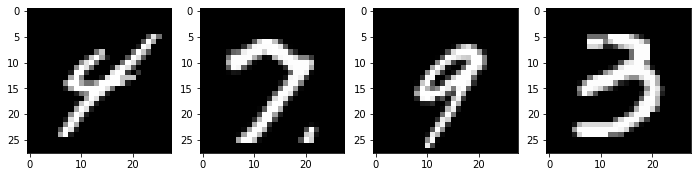

In [33]:
# 샘플 이미지를 출력해보자
import numpy as np
for x,y in train_dl:
  print(x.shape, y.shape)
  break

num=4
img = x[:num]

plt.figure(figsize=(15,15))
for i in range(num):
  plt.subplot(1,num+1,i+1) # nrows, ncols, index
  # Dataloader를 거치며 normalized되었으므로 다시 denormalize하여 출력해야 한다
  # to_pil_image는 tensor Data를 pil image로 변형해주는 함수이다
  plt.imshow(to_pil_image(0.1307*img[i] + 0.3081), cmap="gray")

In [34]:
# Knowledge distillation을 하기 위해 soft label을 얻기 위한 teacher model을 먼저 학습하자
# teacher model을 다음과 같이 정의한다
class Teacher(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,1200)
    self.bn1 = nn.BatchNorm1d(1200)
    self.relu1 = nn.ReLU()
    self.drop1 = nn.Dropout(p=0.8)
    self.fc2 = nn.Linear(1200,1200)
    self.bn2 = nn.BatchNorm1d(1200)
    self.relu2 = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.8)
    self.fc3 = nn.Linear(1200,10)

  def forward(self,x):
    x = x.view(-1,28*28)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.drop1(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.drop2(x)
    x = self.fc3(x)
    return x

In [35]:
# Teacher model에 입력값을 넣고 테스트를 해보자
x = torch.randn(16,1,28,28).to(device)
teacher = Teacher().to(device)
output = teacher(x)
print(output)

tensor([[-0.3389, -1.6431,  0.7968,  0.5736,  0.7454,  0.6468,  1.8093, -1.7720,
          0.3671, -1.7207],
        [-1.2962, -0.4796,  0.6589, -0.7647, -2.3654, -0.2270, -0.0310,  0.6763,
          2.5012,  0.8461],
        [ 0.2039, -0.5975,  0.3290,  0.7841,  1.2047, -1.0596,  0.8631,  1.4324,
          0.4886, -1.4230],
        [-0.0157, -0.2025,  0.9359, -0.7085, -0.7282, -0.6089,  1.3473,  2.4791,
         -1.3084, -1.2400],
        [ 0.4646,  0.2422, -0.2455, -0.6578, -1.0673,  0.7564,  0.3990,  0.0502,
          1.0603,  0.9334],
        [-0.9606, -0.2603, -0.7226, -1.0616,  0.2517,  1.0162, -2.2670,  0.9036,
          1.6993,  2.0685],
        [ 0.6198,  0.1433, -0.4563, -0.0371,  0.4415, -0.2286, -1.4673,  0.3396,
          0.5090,  1.0395],
        [ 0.8614, -0.1932,  0.8354, -0.7852,  1.0638,  0.8401,  0.6140, -0.2054,
         -0.7531,  0.9859],
        [-0.6253, -1.6830,  0.7975,  0.4966,  1.2659, -1.0490,  2.3072,  1.3830,
          0.7982, -1.2676],
        [ 0.6945, -

In [36]:
# 모델의 가중치를 초기화하는 함수를 정의하고
# 해당 모델에 적용한다

def initialize_weights(model):
  classname = model.__class__.__name__

  # 만약 FC Layer라면 다음과 같이 가중치를 초기화한다
  if classname.find("Linear") != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02) # 평균이 0이고 표준편차0.02인 가우시안 정규분포로 초기화
    nn.init.constant_(model.bias.data,0) # Bias는 0으로 초기화

  # batch normalization 게층은 다음과 같이 초기화
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02) # 평균이 1이고 표준편차 0.02인 가우시안 정규분포 난수
    nn.init.constant_(model.bias.data, 0)

teacher.apply(initialize_weights) # teacher모델에 해당 가중치 초기화 함수를 적용한다

Teacher(
  (fc1): Linear(in_features=784, out_features=1200, bias=True)
  (bn1): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.8, inplace=False)
  (fc2): Linear(in_features=1200, out_features=1200, bias=True)
  (bn2): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.8, inplace=False)
  (fc3): Linear(in_features=1200, out_features=10, bias=True)
)

In [37]:
# Teacher model을 학습하기 위한 여러 함수를 정의한다

# 본격적으로 학습을 위한 함수를 제작하자
# 하나의 batch_set의 데이터들의 손실함수가 모두 합산되어 반환되도록 정의
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(teacher.parameters())

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 30회마다 Learning rate를 10분의 1로 줄여주는 Scheduler 제작
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.1, patience=10)

# optimizer의 현재 Learning rate를 반환하는 함수 제작
def get_lr(opt):
  return opt.param_groups[0]['lr']

# model의 예측과 정답 label을 비교하여 맞춘 개수를 반환한다
def metric_batch(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

# batct학습 시 손실함수 이용하여 backpropagation을 하고 나서
# 해당 batch의 총 loss값과 맞은 정답의 개수를 반환하는 함수

def loss_batch(loss_func, outputs, target, opt=None):
  # 만약 Auxiliary Classifier가 적용된 모델이 반환한 값이라면
  # Main Classifier의 반환값, Aux. classifier 1,2의 반환값이 return된다
  if len(outputs) == 3:
    output, aux1, aux2 = outputs
  
    output_loss = loss_func(output, target)
    aux1_loss = loss_func(aux1, target)
    aux2_loss = loss_func(aux2, target)

    # Aux. Classifier의 loss는 0.3을 곱하여 전체 loss에 더한다
    loss = output_loss + 0.3*(aux1_loss + aux2_loss)

    # 해당 batch_dataset에서 model이 맞춘 정답의 개수
    metric_b = metric_batch(output, target)

  else:
    loss = loss_func(outputs, target)
    metric_b = metric_batch(outputs, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b

# 해당 dataloader를 이용해 model을 1 epoch 훈련시키고
# 1epoch동안의 평균 손실함수값과 정확도를 반환하는 함수
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  # epoch 동안의 평균 손실함수값
  # epoch 동안의 평균 Precision 저장을 위한 변수 생성
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb, yb = xb.to(device), yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break

  loss = running_loss  / len_data
  metric = running_metric / len_data

  return loss, metric

# configuration parameter를 params라는 인자로 전달하면
# 해당 config에 맞게 Train을 해주는 함수를 정의하였다
def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  # epoch별 평균 loss와 정확도를 저장
  loss_history = {'train':[], 'val':[]}
  metric_history = {'train':[], 'val':[]}

  # 가장 작은 손실함수값을 반환하는 모델의 가중치를 저장한다
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  start_time = time.time()
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 

    # 학습 모드
    model.train()
    # train_dataset 1 Epoch 훈련
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
    
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # 모델의 성능 평가모드
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print('Loading best model weights!')
      model.load_state_dict(best_model_wts)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

  # 학습을 모두 마치기 전 가장 손실함수가 적게 반환된 가중치로 모델을 초기화한다
  model.load_state_dict(best_model_wts)

  return model, loss_history, metric_history

In [38]:
# Parameter config를 정의하고 학습할 준비를 완료하였다.
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createDir('./models')

In [39]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/29, current lr=0.001
Copied best model weights!
train loss: 0.466418, val loss: 0.161639, accuracy: 94.94, time: 0.2069 min
----------
Epoch 1/29, current lr=0.001
Copied best model weights!
train loss: 0.311681, val loss: 0.128619, accuracy: 95.96, time: 0.4131 min
----------
Epoch 2/29, current lr=0.001
Copied best model weights!
train loss: 0.267931, val loss: 0.111358, accuracy: 96.57, time: 0.6193 min
----------
Epoch 3/29, current lr=0.001
Copied best model weights!
train loss: 0.243413, val loss: 0.106090, accuracy: 96.68, time: 0.8264 min
----------
Epoch 4/29, current lr=0.001
Copied best model weights!
train loss: 0.228286, val loss: 0.096674, accuracy: 97.01, time: 1.0340 min
----------
Epoch 5/29, current lr=0.001
Copied best model weights!
train loss: 0.210308, val loss: 0.091029, accuracy: 97.08, time: 1.2407 min
----------
Epoch 6/29, current lr=0.001
Copied best model weights!
train loss: 0.200573, val loss: 0.086191, accuracy: 97.24, time: 1.4545 min
----------

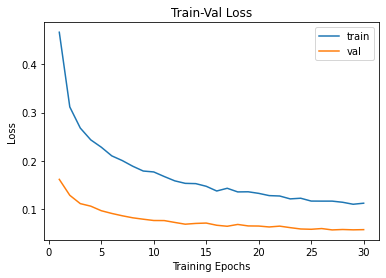

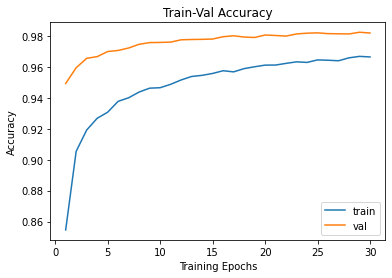

In [40]:
# teacher model이 학습하면서 기록된 loss와 accuracy를 시각화한다
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [41]:
# 이제는 teacher의 지식을 증류하여 transfer할 student model을 정의한다
# Teacher모델보다 작은 규모의 Student모델에 지식을 전달하면
# model compression의 효과가 있어 학습 속도와 성능 모두 긍정적인 효과를 보인다
class Student(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,800)
    self.bn1 = nn.BatchNorm1d(800)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(800,800)
    self.bn2 = nn.BatchNorm1d(800)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(800,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    return x


In [42]:
# Student모델에 input을 넣어서 출력을 정상적으로 나오는지 Test하기
x = torch.randn(16,1,28,28).to(device)
student = Student().to(device)
output = student(x)
print(output.shape)

torch.Size([16, 10])


In [43]:
# Student 모델의 가중치를 초기화하는 함수를 정의하고
# 해당 모델에 적용한다

def initialize_weights(model):
  classname = model.__class__.__name__

  # 만약 FC Layer라면 다음과 같이 가중치를 초기화한다
  if classname.find("Linear") != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02) # 평균이 0이고 표준편차0.02인 가우시안 정규분포로 초기화
    nn.init.constant_(model.bias.data,0) # Bias는 0으로 초기화

  # batch normalization 게층은 다음과 같이 초기화
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02) # 평균이 1이고 표준편차 0.02인 가우시안 정규분포 난수
    nn.init.constant_(model.bias.data, 0)

student.apply(initialize_weights) # teacher모델에 해당 가중치 초기화 함수를 적용한다

Student(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (bn1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=800, out_features=800, bias=True)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=800, out_features=10, bias=True)
)

In [44]:
# teacher model의 soft label을 사용하여 student knowledge distillation loss로 학습
teacher = Teacher().to(device)
teacher.load_state_dict(torch.load("./models/teacher_weights.pt"))

student = Student().to(device)

opt = optim.Adam(student.parameters())

In [45]:
# Knowledge Distillation Loss
# student 모델을 어떻게 학습 시키는가?
# 후에 정의할 Knowledge Distillation Loss를 최소화하도록 학습한다
# 이는 Student model의 Cross Entropy Loss와 Distillation Loss를 더한 값이다

# y : student모델의 soft predicetion
# teacher_scores : teacher모델의 soft prediction
# labels : student의 Hard Label
# T : Temperature
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [46]:
# 하나의 batch를 학습하고 손실함수값과 맞춘 개수를 반환하는 함수
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

In [47]:
import warnings
warnings.filterwarnings(action='ignore')

# 100 epoch분량 학습
num_epochs= 100

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, val_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/99, current lr= 0.001
train loss: 0.032122, val loss: 0.000830, accuracy: 96.97, time: 0.2134 min
----------
Epoch 1/99, current lr= 0.001
train loss: 0.027966, val loss: 0.000698, accuracy: 97.66, time: 0.4275 min
----------
Epoch 2/99, current lr= 0.001
train loss: 0.027443, val loss: 0.000665, accuracy: 97.68, time: 0.6394 min
----------
Epoch 3/99, current lr= 0.001
train loss: 0.027079, val loss: 0.000637, accuracy: 97.73, time: 0.8525 min
----------
Epoch 4/99, current lr= 0.001
train loss: 0.026977, val loss: 0.000597, accuracy: 97.85, time: 1.0638 min
----------
Epoch 5/99, current lr= 0.001
train loss: 0.026813, val loss: 0.000589, accuracy: 97.89, time: 1.2774 min
----------
Epoch 6/99, current lr= 0.001
train loss: 0.026733, val loss: 0.000561, accuracy: 97.94, time: 1.4912 min
----------
Epoch 7/99, current lr= 0.001
train loss: 0.026704, val loss: 0.000573, accuracy: 97.98, time: 1.7032 min
----------
Epoch 8/99, current lr= 0.001
train loss: 0.026576, val loss: 0.